In [113]:
import pandas as pd
import glob
import os
from autorank import autorank, plot_stats, create_report
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgb
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind
# from pymfe.mfe import MFE
from dataset import load_data
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ['DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Palatino', 'Charter', 'serif'],
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.title_fontsize": 12,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "lines.linewidth": 2,
    "lines.markersize": 6,
    "legend.frameon": False,
    "figure.figsize": (9, 3)  # standard size for subplots
})
COLORS = ['#4c90b8', '#2ac3c1', '#f5b811', '#de653e', '#ff912a']
color_dict = {
    'BaselineAll': 'black',
    'BaselineNone': 'gray',
    'DisagreementSampling(DT)': COLORS[3],
    'DisagreementSampling(DS)': COLORS[4],
    'RandomSampling': COLORS[0],
    # add other sampling methods as needed
}

# 0. Load Results Data

In [4]:
# dataset metafeatures
df_meta = pd.read_csv('results/metafeatures.csv')
df_meta = df_meta[df_meta['seed'] == 'average']
df_meta = df_meta.drop(columns=['seed'])
df_meta = df_meta.loc[:, df_meta.nunique(dropna=False) > 1]

In [13]:
# downstream performance and time results
df_all = pd.read_csv('results/tabnet.csv')

df_all['sampling_method'] = df_all['sampling_method'].replace({
    'ConsensusSampling(DT)': 'DisagreementSampling(DT)',
    'ConsensusSampling(DS)': 'DisagreementSampling(DS)'
})

In [51]:
# invert sign for running times
df_all.loc[df_all['metric'] == 'total_time', 'value'] *= -1
df_all.loc[df_all['metric'] == 'sampling_time', 'value'] *= -1
df_all.loc[df_all['metric'] == 'model_time', 'value'] *= -1

# cleaner presentation of brackets
df_clean = df_all.copy()
bracket_cleaner = {40: '0-40', 60: '20-60', 80: '40-80', 100: '60-100', 0: 'all', np.nan: 'all'}
df_clean['bracket'] = df_clean['bracket_max'].map(bracket_cleaner)
df_clean = df_clean.drop(['bracket_min', 'bracket_max', 'mean', 'sampling_strategy', 'n_selected'], axis=1)

# joining corresponding baselines
baseline_none = df_clean[df_clean['sampling_method'] == 'BaselineNone'].drop(['bracket', 'sampling_method', 'n_sample'], axis=1).rename(columns={'value': 'baseline_none'})
baseline_all = df_clean[df_clean['sampling_method'] == 'BaselineAll'].drop(['bracket', 'sampling_method', 'n_sample'], axis=1).rename(columns={'value': 'baseline_all'})
df_clean = df_clean[~df_clean['sampling_method'].isin(['BaselineNone', 'BaselineAll'])]
join_keys = ['dataset', 'n_labeled', 'metric', 'seed']
df_clean = pd.merge(df_clean, baseline_none, on=join_keys, how='left')
df_clean = pd.merge(df_clean, baseline_all, on=join_keys, how='left')
df_clean_avg = df_clean.groupby(['dataset', 'n_labeled', 'n_sample', 'sampling_method', 'metric', 'bracket'])[['value', 'baseline_none', 'baseline_all']].mean().reset_index()

# finding the best bracket by AUPRC
df_agg = df_clean_avg[df_clean_avg['metric'] == 'auprc_macro']
idx_max_value = df_agg.groupby(['dataset', 'n_labeled', 'sampling_method', 'n_sample'])['value'].idxmax()
df_best_bracket = df_agg.loc[idx_max_value]
idx_max_value = df_agg.groupby(['dataset', 'n_labeled', 'sampling_method'])['value'].idxmax()
df_best_nsample_bracket = df_agg.loc[idx_max_value]

In [15]:
# categorical metafeatures (low/medium/high)
df_meta_cat = df_meta.copy()
df_meta_cat = df_meta_cat.loc[:, df_meta_cat.nunique(dropna=False) > 2]
feature_cols = [col for col in df_meta_cat.columns if col != "dataset_id"]

# Apply quantile-based binning to each feature
for col in feature_cols:
    try:
        df_meta_cat[col] = pd.qcut(df_meta_cat[col], q=3, labels=["low", "medium", "high"])
    except:
        continue

# 1. Sampling vs. All Unlabeled Data vs. None (Rank)

Does sampling generally work?

In [58]:
# df_tmp = df_best_nsample_bracket.copy()

# # add columns indicating where sampling beats the baselines
# df_tmp['beats_baseline_none'] = df_tmp['value'] > df_tmp['baseline_none']
# df_tmp['beats_baseline_all'] = df_tmp['value'] > df_tmp['baseline_all']

# # for all rows where sampling beats the baseline, extract all data with the corresponding configuration 
# #   (=same dataset and n_labeled and n_sample and sampling_method and metric) from df_clean
# # run t-tests to compare to baselines
# baseline_none_pvalues = []
# baseline_all_pvalues = []
# for index,row in df_tmp.iterrows():
#     df_t = df_clean[
#         (df_clean['dataset'] == row['dataset']) &
#         (df_clean['n_labeled'] == row['n_labeled']) &
#         (df_clean['n_sample'] == row['n_sample']) &
#         (df_clean['sampling_method'] == row['sampling_method']) &
#         (df_clean['metric'] == row['metric'])&
#         (df_clean['bracket'] == row['bracket'])
#     ][['value', 'baseline_all', 'baseline_none']]
#     baseline_none_pvalues.append(float(ttest_ind(df_t['value'], df_t['baseline_none']).pvalue))
#     baseline_all_pvalues.append(float(ttest_ind(df_t['value'], df_t['baseline_all']).pvalue))
# df_tmp['baseline_none_pvalue'] = baseline_none_pvalues
# df_tmp['baseline_all_pvalue'] = baseline_all_pvalues

# # is the difference significant with a p-value < 0.05?
# df_tmp['beats_baseline_none_significant'] = (df_tmp['baseline_none_pvalue'] < 0.05) & df_tmp['beats_baseline_none']
# df_tmp['beats_baseline_all_significant'] = (df_tmp['baseline_all_pvalue'] < 0.05) & df_tmp['beats_baseline_all']

# pivot_summary = pd.pivot_table(
#     df_tmp,
#     index=['n_labeled', 'sampling_method'],
#     values=['beats_baseline_none', 'beats_baseline_none_significant', 'beats_baseline_all', 'beats_baseline_all_significant', 'dataset'],  # Added 'dataset' to values
#     aggfunc={
#         'beats_baseline_none': 'sum',
#         'beats_baseline_none_significant': 'sum',
#         'beats_baseline_all': 'sum',
#         'beats_baseline_all_significant': 'sum',
#         'dataset': 'nunique'  # Added nunique for dataset
#     }
# )
# pivot_summary['Beats BaselineAll (significantly)'] = pivot_summary.apply(
#     lambda row: f"{int(row['beats_baseline_all'])} ({int(row['beats_baseline_all_significant'])}*)",
#     axis=1
# )
# pivot_summary['Beats BaselineNone (significantly)'] = pivot_summary.apply(
#     lambda row: f"{int(row['beats_baseline_none'])} ({int(row['beats_baseline_none_significant'])}*)",
#     axis=1
# )
# pivot_summary = pivot_summary.drop(columns=['beats_baseline_none', 'beats_baseline_none_significant', 'beats_baseline_all', 'beats_baseline_all_significant'])
# pivot_summary.rename(columns={'dataset': 'Total Datasets'}, inplace=True)


In [59]:
# df_tmp = df_best_nsample_bracket.copy()

# # add columns indicating where sampling beats the baselines
# df_tmp['equal_baseline_none'] = np.abs((df_tmp['value'] - df_tmp['baseline_none'])/df_tmp['baseline_none']) < 0.02
# df_tmp['equal_baseline_all'] = np.abs((df_tmp['value'] - df_tmp['baseline_all'])/df_tmp['baseline_all']) < 0.02

# pivot_summary = pd.pivot_table(
#     df_tmp,
#     index=['n_labeled', 'sampling_method'],
#     values=['equal_baseline_none', 'equal_baseline_all', 'dataset'], 
#     aggfunc={
#         'equal_baseline_none': 'sum',
#         'equal_baseline_all': 'sum',
#         'dataset': 'nunique'  # Added nunique for dataset
#     }
# )
# pivot_summary['Within 2% margin of BaselineAll'] = pivot_summary.apply(
#     lambda row: f"{int(row['equal_baseline_all'])}",
#     axis=1
# )
# pivot_summary['Within 2% margin of BaselineNone'] = pivot_summary.apply(
#     lambda row: f"{int(row['equal_baseline_none'])}",
#     axis=1
# )
# pivot_summary = pivot_summary.drop(columns=['equal_baseline_none', 'equal_baseline_all'])
# pivot_summary.rename(columns={'dataset': 'Total Datasets'}, inplace=True)


In [56]:
df_tmp = df_best_nsample_bracket.copy()

# add columns indicating where sampling beats the baselines
df_tmp['of_baseline_all'] = (df_tmp['value'] / df_tmp['baseline_all'])*100
df_tmp['of_baseline_none'] = (df_tmp['value'] / df_tmp['baseline_none'])*100
df_tmp['none_of_all'] = (df_tmp['baseline_none'] / df_tmp['baseline_all'])*100

pivot_summary = pd.pivot_table(
    df_tmp,
    index=['n_labeled', 'sampling_method'],
    values=['of_baseline_all', 'of_baseline_none', 'none_of_all'],#, 'dataset'], 
    aggfunc={
        'of_baseline_all': 'mean',
        'of_baseline_none': 'mean',
        'none_of_all': 'mean',
        # 'dataset': 'nunique'  # Added nunique for dataset
    }
)
pivot_summary['BaselineNone % of BaselineAll'] = pivot_summary.apply(
    lambda row: f"{int(row['none_of_all'])}",
    axis=1
)
pivot_summary['% of BaselineAll'] = pivot_summary.apply(
    lambda row: f"{int(row['of_baseline_all'])}",
    axis=1
)
pivot_summary['% of BaselineNone'] = pivot_summary.apply(
    lambda row: f"{int(row['of_baseline_none'])}",
    axis=1
)

pivot_summary = pivot_summary.drop(columns=['of_baseline_all', 'of_baseline_none', 'none_of_all'])
pivot_summary.rename(columns={'dataset': 'Total Datasets'}, inplace=True)


In [57]:
pivot_summary

BaselineNone % of BaselineAll  \
n_labeled sampling_method                                          
50        DisagreementSampling(DS)                            96   
          DisagreementSampling(DT)                            96   
          RandomSampling                                      96   
100       DisagreementSampling(DS)                            90   
          DisagreementSampling(DT)                            90   
          RandomSampling                                      90   
150       DisagreementSampling(DS)                            90   
          DisagreementSampling(DT)                            90   
          RandomSampling                                      90   
200       DisagreementSampling(DS)                            90   
          DisagreementSampling(DT)                            90   
          RandomSampling                                      90   
350       DisagreementSampling(DS)                            90   
          DisagreementSampling(DT)                            90   
          RandomSampling                                      90   
500       DisagreementSampling(DS)                            91   
          DisagreementSampling(DT)                            91   
          RandomSampling                                      91   
750       DisagreementSampling(DS)                            94   
          DisagreementSampling(DT)                            94   
          RandomSampling                                      94   
1000      DisagreementSampling(DS)                            95   
          DisagreementSampling(DT)                            95   
          RandomSampling                                      95   

                                   % of BaselineAll % of BaselineNone  
n_labeled sampling_method                                              
50        DisagreementSampling(DS)              104               109  
          DisagreementSampling(DT)              104               108  
          RandomSampling                         99               103  
100       DisagreementSampling(DS)               97               107  
          DisagreementSampling(DT)               96               107  
          RandomSampling                         94               104  
150       DisagreementSampling(DS)               99               110  
          DisagreementSampling(DT)               99               110  
          RandomSampling                         96               107  
200       DisagreementSampling(DS)               96               108  
          DisagreementSampling(DT)               97               109  
          RandomSampling                         95               106  
350       DisagreementSampling(DS)               94               105  
          DisagreementSampling(DT)               95               106  
          RandomSampling                         93               103  
500       DisagreementSampling(DS)               95               106  
          DisagreementSampling(DT)               96               106  
          RandomSampling                         95               105  
750       DisagreementSampling(DS)               97               104  
          DisagreementSampling(DT)               96               104  
          RandomSampling                         96               103  
1000      DisagreementSampling(DS)               97               103  
          DisagreementSampling(DT)               97               103  
          RandomSampling                         97               102

In [61]:
# latex_str = pivot_summary.to_latex(index=True, escape=False)
# print(latex_str)

# 2. n_sample

How much do we need to sample?

In [93]:
df_plot = df_best_bracket.copy()
df_plot['% of BaselineAll'] = 100 * df_plot['value'] / df_plot['baseline_all']
df_plot['sampling_method'] = df_plot['sampling_method'].astype(str)

# Add baseline lines as "sampling methods", preserving n_labeled
df_none = df_plot[['n_sample', 'n_labeled', 'baseline_none', 'baseline_all']].copy()
df_none['% of BaselineAll'] = 100 * df_none['baseline_none'] / df_none['baseline_all']
df_none['sampling_method'] = 'BaselineNone'

df_all = df_plot[['n_sample', 'n_labeled']].drop_duplicates().copy()
df_all['% of BaselineAll'] = 100
df_all['sampling_method'] = 'BaselineAll'

df_plot = pd.concat([
    df_plot[['n_sample', 'n_labeled', 'sampling_method', '% of BaselineAll']],
    df_none[['n_sample', 'n_labeled', 'sampling_method', '% of BaselineAll']],
    df_all
], ignore_index=True)

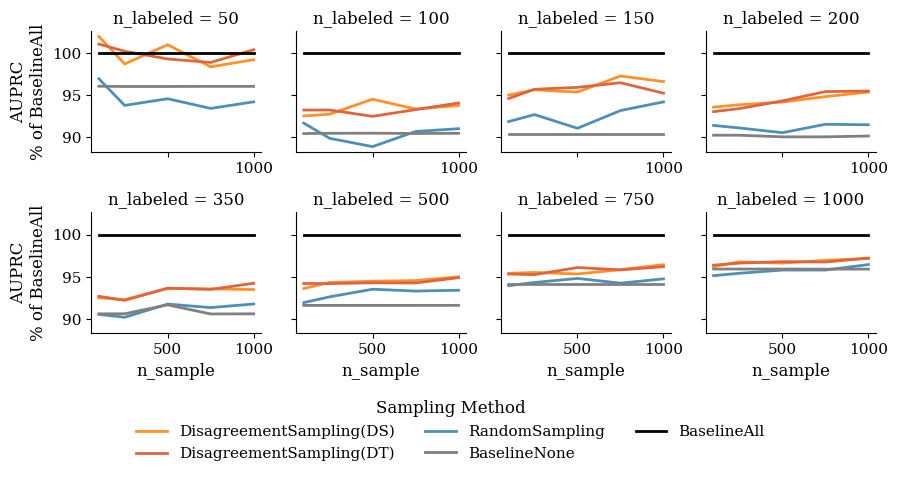

In [107]:
g = sns.relplot(
    data=df_plot,
    x='n_sample',
    y='% of BaselineAll',
    hue='sampling_method',
    col='n_labeled',
    kind='line',
    palette=color_dict,
    facet_kws={'sharey': True, 'sharex': True},
    col_wrap=4,
    errorbar=None,
    height=2, aspect=0.8,
)

g.set_axis_labels('n_sample', 'AUPRC\n% of BaselineAll')

# Force legend creation if missing
g._legend.remove()
g._legend = g.fig.legend(
    handles=g._legend_data.values(),
    labels=g._legend_data.keys(),
    title='Sampling Method',
    loc='lower center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=3,
    frameon=False
)

plt.subplots_adjust(bottom=0.25)  # Adjust space to make room
plt.tight_layout()
plt.savefig('plots/1_2_nsample_split_by_nlabeled.pdf', bbox_inches='tight')
plt.show()

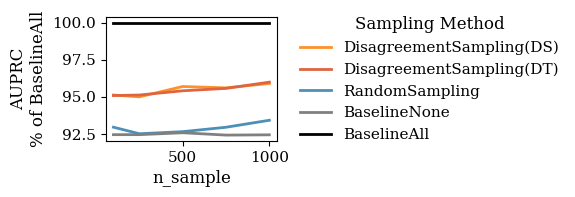

In [108]:
fig, ax = plt.subplots(figsize=(6, 2))  # Set width and height in inches

g = sns.lineplot(
    data=df_plot,
    x='n_sample',
    y='% of BaselineAll',
    hue='sampling_method',
    palette=color_dict,
    errorbar=None,
    ax=ax
)

ax.set_xlabel('n_sample')
ax.set_ylabel('AUPRC\n% of BaselineAll')

# Move legend to the right outside the plot
legend = ax.legend(
    title='Sampling Method',
    bbox_to_anchor=(1.1, 0.5),
    loc='center left',
    borderaxespad=0,
    frameon=False
)

plt.tight_layout()
plt.savefig('plots/1_2_nsample.pdf', bbox_inches='tight')
plt.show()

# 3. Brackets

Which disagreement bracket makes the most sense?

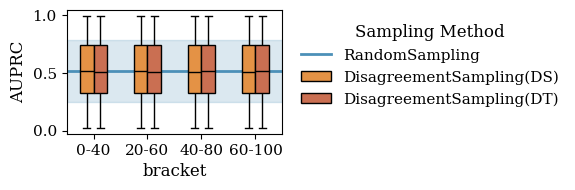

In [122]:
df_plot = df_clean[df_clean['metric'] == 'auprc_macro']
rand_vals = df_plot[df_plot['sampling_method'] == 'RandomSampling']['value']
rand_mean = rand_vals.mean()
rand_std = rand_vals.std()

plt.figure(figsize=(6, 2))
ax = plt.gca()

# Add horizontal band for RandomSampling
ax.axhline(rand_mean, color=color_dict['RandomSampling'], linestyle='-', label='RandomSampling')
ax.fill_between(
    x=[-0.5, len(df_plot['bracket'].unique()) - 1.5],
    y1=rand_mean - rand_std,
    y2=rand_mean + rand_std,
    color=color_dict['RandomSampling'],
    alpha=0.2
)

sns.boxplot(
    data=df_plot[df_plot['sampling_method'] != 'RandomSampling'],
    x="bracket",
    y="value",
    hue="sampling_method",
    palette=color_dict,
    width=0.5
)

plt.ylabel('AUPRC')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Sampling Method', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

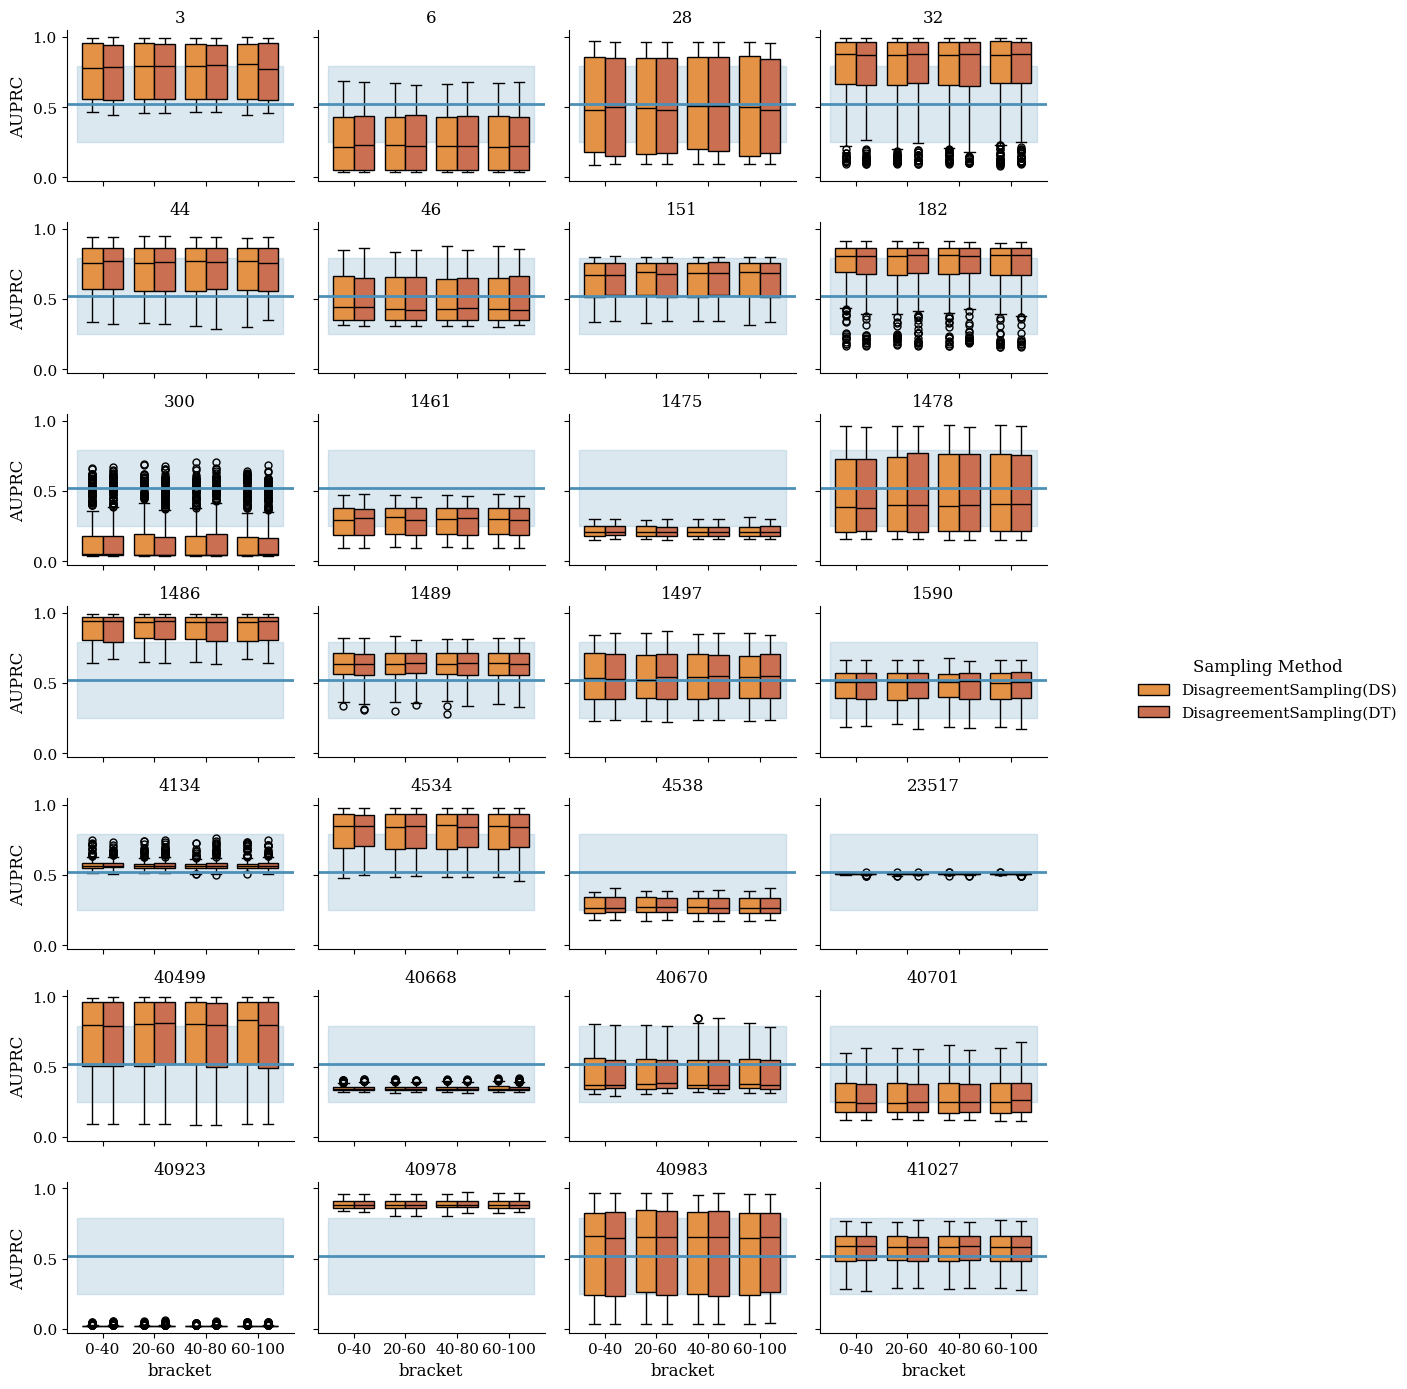

In [138]:
# Filter relevant data
df_plot = df_clean[df_clean['metric'] == 'auprc_macro']
rand_vals = df_plot[df_plot['sampling_method'] == 'RandomSampling']['value']
rand_mean = rand_vals.mean()
rand_std = rand_vals.std()

# Exclude RandomSampling from the boxplot data
df_no_rand = df_plot[df_plot['sampling_method'] != 'RandomSampling']

# Create faceted boxplots by dataset
g = sns.catplot(
    data=df_no_rand,
    x="bracket",
    y="value",
    hue="sampling_method",
    col="dataset",
    col_wrap=4,
    kind="box",
    palette=color_dict,
    height=2,
    aspect=1,
    sharey=True
)

# Add horizontal line and band to each subplot
for ax in g.axes.flat:
    ax.axhline(rand_mean, color=color_dict['RandomSampling'], linestyle='-')
    ax.fill_between(
        x=[-0.5, len(df_plot['bracket'].unique()) - 1.5],
        y1=rand_mean - rand_std,
        y2=rand_mean + rand_std,
        color=color_dict['RandomSampling'],
        alpha=0.2,
        zorder=0
    )

g.set_titles(col_template="{col_name}")
g.set_axis_labels("bracket", "AUPRC")

# Adjust legend
g._legend.set_title("Sampling Method")
g._legend.set_bbox_to_anchor((1.05, 0.5))
g._legend.set_loc("center left")

plt.tight_layout()
plt.show()

In [137]:
sorted_features

[('iq_range.min', np.float64(9.316559102472842e-05)),
 ('var_importance.min', np.float64(8.732350817989209e-05)),
 ('nodes_repeated.min', np.float64(8.415254732809088e-05)),
 ('mad.min', np.float64(8.115070384098146e-05)),
 ('freq_class.mean', np.float64(4.901527104208299e-05)),
 ('nr_cat', np.float64(4.2271042836627084e-05)),
 ('num_to_cat', np.float64(3.585146746175749e-05)),
 ('cat_to_num', np.float64(3.5715562957821194e-05)),
 ('nr_class', np.float64(2.0382177110294325e-05)),
 ('leaves_per_class.mean', np.float64(2.038217711029432e-05)),
 ('nr_norm', np.float64(2.0377279902251697e-05)),
 ('nr_bin', np.float64(1.968494834664948e-05)),
 ('n_labeled', np.float64(1.4669581397914305e-05)),
 ('one_itemset.min', np.float64(1.1149259829105432e-05)),
 ('ns_ratio', np.float64(7.474643228967287e-06)),
 ('attr_conc.max', np.float64(7.058880603036274e-06)),
 ('mut_inf.mean', np.float64(7.024649171145313e-06)),
 ('class_conc.mean', np.float64(6.565449270857778e-06)),
 ('mut_inf.max', np.float64(

# 4. Bracket Recommender

We can get good results, but when should we use which bracket? Let's train a model on the dataset features and find out. 

### 4a. Bracket Recommender: Performance

### 4b. Bracket Recommender: Feature Importance